In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import time
from scipy import stats
import heapq
import warnings


Queuing theory tells us that for FIFO scheduling the average waiting times are shorter for an
$M/M/n$ queue and a system load $\rho$ and processor capacity $\mu$ than for a single $M/M/1$ queue
with the same load characteristics (and thus an n-fold lower arrival rate). Of course, $\rho$ must be
less than one, but the experiment only becomes interesting when $\rho$ is not much less than one.

$\lambda$ then becomes $\lambda = \rho*n*\mu$.

Code sources: "https://simpy.readthedocs.io/en/latest/examples/bank_renege.html" and "https://www.youtube.com/watch?v=eSNfC-HOl44"

In [5]:
# M/M/1 (M/M/n) queueing system
def generate_interarrival(mu,n,rho):
    return random.expovariate(mu*n*rho)


def source(env, n, rho, mu, servers, que_arr):
    """Source generates customers randomly based on exponential distribution"""
    i = 0
    while True:
        i += 1
        c = customer(env, i, servers, mu, que_arr)
        env.process(c)
        t = random.expovariate(mu*n*rho)
        yield env.timeout(t)   

total_waiting_time = []

def customer(env, customer, servers, mu, que_arr):
    """This generator function models the behavior of a customer in the queue."""
    time_of_arrival = env.now
    que_arr.append((env.now, len(servers.queue)))
    with servers.request() as req:    
        #print(env.now, 'customer {} arrives'.format(customer))
        yield req
        time_of_handling = random.expovariate(mu)
        #print(env.now, 'customer {} is being served'.format(customer))
        yield env.timeout(time_of_handling)
        waiting_time = env.now
        #print(env.now, 'customer {} departs'.format(customer))
        total_waiting_time.append((env.now, waiting_time-time_of_arrival))

### Setup and start the simulation

# Initial values            
mu = 1  # Parameter mu
rho = 0.9 #[0.7,0.85,0.9,0.95,0.99] # Parameter rho (varying for values close to 1)
n = 2 # Number of servers, in our case 1, 2 and 4

env = simpy.Environment()
que_arr =[]
# Start processes and run
servers = simpy.Resource(env, capacity=n)
env.process(source(env, n, rho, mu, servers, que_arr))
env.run(until=200)
print(f"Total customers served: {len(total_waiting_time)}")


Total customers served: 314


In [7]:
# Defining function for simulating M/M/n queue system

# Setup and start the simulation
def sim_run(n,rho,mu,sim_duration):
    env = simpy.Environment()
    # Start processes and run
    que_arr =[]
    servers = simpy.Resource(env, capacity=n)
    env.process(source(env, n, rho, mu, servers, que_arr))
    env.run(until=sim_duration)
    return total_waiting_time, que_arr
    
mean_queue_lengths = pd.DataFrame()
rho_vals = [0.85,0.9,0.95,0.99]
serv = [1, 2, 4]
sim_time = 200
mu = 1.0         
all_results = []
second_data_que = []
mean_vaiting = []
all_results_mean = []
z_score = 1.96
mean_std_ci_queue_lengths = pd.DataFrame()
mean_std_ci_waiting_time = pd.DataFrame()
waiting_time_general_stat = pd.DataFrame()
simulations = 10
# The loops to go through numb. of servers and p value
for server in serv:
    for p_value in rho_vals:
        #I defne all arrays and vars that are reused for each params.
        second_data_que = []
        mean_vaiting = []
        mean_waiting_data_for_statistics = []
        std_waiting_data_for_statistics = []
        customers_srvd_stat = []
        queue_stat = []
        maxim = -np.inf
        minim = np.inf
        maxim_que = -np.inf
        minim_que = np.inf
        maxim_customers_served = -np.inf
        minim_customers_served = np.inf
        #Run simulations
        for run in range(simulations):
            #Run and extract data from simulation 
            waiting_data, queue_data = sim_run(server,p_value,mu,sim_time)
            #Here I calculate everything for dataframe that will calculate overall atatistics for n simulations
            f = lambda a: a[1]
            waiting_data_true = list(map(f, waiting_data))
            queue_data_true = list(map(f, queue_data))
            mean_queue_cur_sim = np.mean(queue_data_true)
            mean_waiting_cur_sim = np.mean(waiting_data_true)
            max_waiting = np.max(waiting_data_true)
            maxim = max(max_waiting, maxim)
            min_waiting = np.min(waiting_data_true)
            minim = min(min_waiting, minim)
            max_que = np.max(queue_data_true)
            maxim_que = max(max_que, maxim_que)
            min_que = np.min(queue_data_true)
            minim_que = min(min_que, minim_que)
            customer_served = len(waiting_data_true)
            maxim_customers_served = max(customer_served, maxim_customers_served)
            minim_customers_served = min(customer_served, minim_customers_served)
            std_within_sim_waiting = np.std(waiting_data_true)
            mean_waiting_data_for_statistics.append(mean_waiting_cur_sim)
            std_waiting_data_for_statistics.append(std_within_sim_waiting)
            queue_stat.append(mean_queue_cur_sim)
            customers_srvd_stat.append(customer_served)
            # Here I create dataframes for interday statistics for n sims
            df_queue = pd.DataFrame(queue_data, columns=['Time', 'Queue_Length'])
            df_queue['Time'] = df_queue['Time'].round().astype(int) // 100
            df_second_mean = df_queue.groupby('Time').mean()
            second_data_que.append(df_second_mean)
            df_waiting = pd.DataFrame(waiting_data, columns=['Time', 'Waiting_time'])
            df_waiting['Time'] = df_waiting['Time'].round().astype(int) // 100
            df_waiting_mean = df_waiting.groupby('Time').mean()
            mean_vaiting.append(df_waiting_mean)
        #All calculations related to daily dataframes. Basically two dtatframes with mean value for every 100 days 
        for second in range(0, int(sim_time/100)):
            interval_data = [pd.Series(df.loc[second]['Queue_Length']) if second in df.index else pd.Series([0]) for df in second_data_que]
            concatenated_data = pd.concat(interval_data, ignore_index=True)
            mean_length = concatenated_data.mean()
            std_dev = concatenated_data.std()
            margin_of_error = z_score * (std_dev / np.sqrt(len(concatenated_data)))
            lower_bound = mean_length - margin_of_error
            upper_bound = mean_length + margin_of_error
            mean_std_ci_queue_lengths = mean_std_ci_queue_lengths._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Queue_Length': mean_length,
                'Std_Dev_Queue_Length': std_dev,
                'CI_Lower_Bound': lower_bound,
                'CI_Upper_Bound': upper_bound
            }, ignore_index=True)
            interval_data_waiting = [pd.Series(df.loc[second]['Waiting_time']) if second in df.index else pd.Series() for df in mean_vaiting]
            concatenated_data_waiting = pd.concat(interval_data_waiting, ignore_index=True)
            mean_length_waiting = concatenated_data_waiting.mean()
            std_dev_waiting = concatenated_data_waiting.std()
            confidence_waiting_time = z_score * (std_dev_waiting / np.sqrt(len(concatenated_data_waiting)))
            lower_bound_waiting = mean_length_waiting - confidence_waiting_time
            upper_bound_waiting = mean_length_waiting + confidence_waiting_time
            mean_std_ci_waiting_time = mean_std_ci_waiting_time._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Waiting_time': mean_length_waiting,
                'Std_Dev_Waiting_time': std_dev_waiting,
                'CI_Lower_Bound': lower_bound_waiting,
                'CI_Upper_Bound': upper_bound_waiting
            }, ignore_index=True)
        # All calculations for overall statistics over 100 simulations
        whole_sim_mean = np.mean(mean_waiting_data_for_statistics) 
        whole_sim_within_std = np.mean(std_waiting_data_for_statistics)
        std_whole_sim = np.std(mean_waiting_data_for_statistics)  
        std_fr_std_whole_sim = np.std(std_waiting_data_for_statistics)  
        confidence_waiting_time_whole = z_score * (std_whole_sim / np.sqrt(len(mean_waiting_data_for_statistics)))
        lower_bound_waiting_whole = whole_sim_mean - confidence_waiting_time_whole
        upper_bound_waiting_whole = whole_sim_mean + confidence_waiting_time_whole   
        confidence_waiting_std_within = z_score * (std_fr_std_whole_sim / np.sqrt(len(std_waiting_data_for_statistics)))
        lower_bound_waiting_std_within = whole_sim_within_std - confidence_waiting_std_within
        upper_bound_waiting_std_within = whole_sim_within_std + confidence_waiting_std_within 
        customers_served_mean = np.mean(customers_srvd_stat)
        customers_served_std = np.std(customers_srvd_stat)
        confidence_customers_served = z_score * (customers_served_std / np.sqrt(len(customers_srvd_stat)))
        lower_bound_customers_served = customers_served_mean - confidence_customers_served
        upper_bound_customers_served = customers_served_mean + confidence_customers_served 
        mean_que = np.mean(queue_stat)
        std_que = np.mean(queue_stat)
        confidence_que = z_score * (std_que / np.sqrt(len(queue_stat)))
        lower_bound_que = mean_que - confidence_que
        upper_bound_que = mean_que + confidence_que 
        waiting_time_general_stat = waiting_time_general_stat._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Mean_Waiting_time': whole_sim_mean,
                'Mean_Within_Std_of_Waiting_time': whole_sim_within_std,
                'Customers_Served': customers_served_mean,
                'Mean_queue': mean_que,
                'Std_within_Waiting_time': std_fr_std_whole_sim,
                'Std_Dev_Waiting_time': std_whole_sim,
                'Std_Dev_Customers_served': customers_served_std,
                'Std_Dev_Queue': std_que,
                'CI_Lower_Bound_Mean': lower_bound_waiting_whole,
                'CI_Upper_Bound_Mean': upper_bound_waiting_whole,
                'CI_Lower_Bound_Std': lower_bound_waiting_std_within,
                'CI_Upper_Bound_Std': upper_bound_waiting_std_within, 
                'CI_Lower_Bound_Customers_Served': lower_bound_customers_served,
                'CI_Upper_Bound_Customers_Served': upper_bound_customers_served, 
                'CI_Lower_Bound_Queue': lower_bound_que,
                'CI_Upper_Bound_Queue': upper_bound_que, 
                'Min_waiting_time': minim,
                'Max_waiting_time': maxim,
                'Min_queue': minim_que,
                'Max_queue': maxim_que,
                'Min_customers_served': minim_customers_served,
                'Max_customers_served': maxim_customers_served
                }, ignore_index=True)



        
 

In [ ]:
# Plot the mean and standard deviation of the waiting time

SJF implementation

#1 Preemptive SJF

In [435]:
def source(env, mu, n, rho, queue, q_arr):
    """Function that summons people and pushes them to the heap queue (each parent has higher priority that his two children)."""
    while True:
        #Create a service time
        time_of_handling = random.expovariate(mu)
        arrival_time = env.now
        heapq.heappush(queue, (time_of_handling, arrival_time))
        #Time to next customer
        tm = random.expovariate(mu*n*rho)        
        q_arr.append((env.now, len(queue)))
        yield env.timeout(tm)
        

def do_work(env, client, servers, time_to_finish, total_waiting_time):
    """ Function that processes the customer by yielding timeout and equesting resource"""
    with servers.request() as req:
        yield req
        yield env.timeout(time_to_finish)
        #Total waiting time
        total_waiting_time.append((env.now,env.now - client))


def customer_initialise(env, servers, queue, total_waiting_time, q_arr):
    while True:
        # Check if there is que and if any resourses are free
        if queue and servers.count < servers.capacity:
                time_to_finish, client = heapq.heappop(queue)
                env.process(do_work(env, client, servers, time_to_finish, total_waiting_time))
                q_arr.append((env.now, len(queue)))
                #Timeout to not send all people from my queue to the buildin Simpy fcfs queue and check "if queue and servers.count < servers.capacity:" again
                yield env.timeout(0.001)
        else:
            #Timeout to not be stuck in the loop
            yield env.timeout(0.01)


mu = 1.0          
n = 4             
rho = 1       
sim_time = 200    
env = simpy.Environment()
servers = simpy.Resource(env,capacity=n)
priority_queue = []
total_waiting_time = []
q_arr = []
print(priority_queue)
env.process(source(env, mu, n, rho, priority_queue, q_arr))
env.process(customer_initialise(env, servers, priority_queue, total_waiting_time, q_arr))
env.run(until=sim_time)
print(f"Total customers served: {len(total_waiting_time)}")


[]
Total customers served: 828


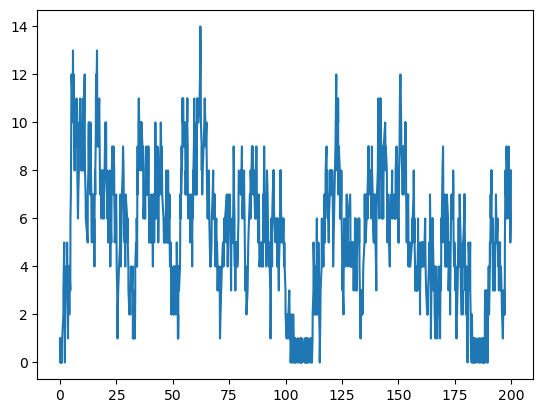

In [431]:
x = []
y = []
for i in q_arr:
    x.append(i[0])
    y.append(i[1])
plt.plot(x, y)

#2 Non preemptive SJF (halting the precesses if faster customer arrives)

In [256]:
#Here I created client class so it is more convinient to resend someone back to the que and rember his time_of_handling that is left
class Client:
    def __init__(self, time_of_arrival, time_of_handling):
        self.time_of_arrival = time_of_arrival
        self.time_of_handling = time_of_handling

def source_preemptive(env, mu, n, rho, queue, q_arr):
    while True:
        time_of_handling = random.expovariate(mu)
        arrival_time = env.now
        heapq.heappush(queue, (time_of_handling, Client(arrival_time, time_of_handling)))
        mean_queue.append(len(queue))
        yield env.timeout(random.expovariate(mu*n*rho))

def do_work_preemptive(env, client, servers, time_to_finish, total_waiting_time, queue):
    with servers.request() as req:
        yield req
        #It should be the last time someone is processed
        if time_to_finish <= 0.01:
            yield env.timeout(time_to_finish)
            #Record total waiting time
            total_waiting_time.append(env.now - client.time_of_arrival)
        else:
            #Here I resend someone to the queue and sice it is heap queue if he has the least waiting time he will be processed next or someone with less waiting time
            yield env.timeout(0.01)
            arrival_time = client.time_of_arrival
            time_of_handling = client.time_of_handling - 0.01
            heapq.heappush(queue, (time_of_handling, Client(arrival_time, time_of_handling)))
            
def customer_initialise_preemptive(env, servers, queue, total_waiting_time, q_arr):
    while True:
        if queue and servers.count < servers.capacity:
            time_to_finish, client = heapq.heappop(queue)
            env.process(do_work_preemptive(env, client, servers, time_to_finish, total_waiting_time, queue))
        else:
            yield env.timeout(0.005)


    

mu = 1.0         
n = 2             
rho = 0.95         
sim_time = 150
env = simpy.Environment()
servers = simpy.Resource(env,capacity=n)
priority_queue = []
total_waiting_time = []
mean_queue = []
mean_waiting_time = []
q_arr = [] 
env.process(source_preemptive(env, mu, n, rho, priority_queue, q_arr))
env.process(customer_initialise_preemptive(env, servers, priority_queue, total_waiting_time, q_arr))
env.run(until=sim_time)
print(f"Que length mean: {q_arr}")
print(f"Total customers served: {len(total_waiting_time)}")
print(f"Average waiting time: {sum(total_waiting_time) / len(total_waiting_time)}")

Que length mean: []
Total customers served: 280
Average waiting time: 6.673131816580441


/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


#3 Data analysis

In [639]:
warnings.simplefilter(action='ignore', category=FutureWarning)
def sim_run(n,rho,mu,sim_time):
    """Function to run a simulation"""
    env = simpy.Environment()
    servers = simpy.Resource(env,capacity=n)
    priority_queue = []
    total_waiting_time = []
    q_arr = [] 
    env.process(source(env, mu, n, rho, priority_queue, q_arr))
    env.process(customer_initialise(env, servers, priority_queue, total_waiting_time, q_arr))
    env.run(until=sim_time)
    return total_waiting_time, q_arr
mean_queue_lengths = pd.DataFrame()
rho_vals = [0.85,0.9,0.95,0.99]
serv = [1, 2, 4]
sim_time = 20000
mu = 1.0         
all_results = []
second_data_que = []
mean_vaiting = []
all_results_mean = []
z_score = 1.96
mean_std_ci_queue_lengths = pd.DataFrame()
mean_std_ci_waiting_time = pd.DataFrame()
waiting_time_general_stat = pd.DataFrame()
simulations = 100
# The loops to go through numb. of servers and p value
for server in serv:
    for p_value in rho_vals:
        #I defne all arrays and vars that are reused for each params.
        second_data_que = []
        mean_vaiting = []
        mean_waiting_data_for_statistics = []
        std_waiting_data_for_statistics = []
        customers_srvd_stat = []
        queue_stat = []
        maxim = -np.inf
        minim = np.inf
        maxim_que = -np.inf
        minim_que = np.inf
        maxim_customers_served = -np.inf
        minim_customers_served = np.inf
        #Run simulations
        for run in range(simulations):
            #Run and extract data from simulation 
            waiting_data, queue_data = sim_run(server,p_value,mu,sim_time)
            #Here I calculate everything for dataframe that will calculate overall atatistics for n simulations
            f = lambda a: a[1]
            waiting_data_true = list(map(f, waiting_data))
            queue_data_true = list(map(f, queue_data))
            mean_queue_cur_sim = np.mean(queue_data_true)
            mean_waiting_cur_sim = np.mean(waiting_data_true)
            max_waiting = np.max(waiting_data_true)
            maxim = max(max_waiting, maxim)
            min_waiting = np.min(waiting_data_true)
            minim = min(min_waiting, minim)
            max_que = np.max(queue_data_true)
            maxim_que = max(max_que, maxim_que)
            min_que = np.min(queue_data_true)
            minim_que = min(min_que, minim_que)
            customer_served = len(waiting_data_true)
            maxim_customers_served = max(customer_served, maxim_customers_served)
            minim_customers_served = min(customer_served, minim_customers_served)
            std_within_sim_waiting = np.std(waiting_data_true)
            mean_waiting_data_for_statistics.append(mean_waiting_cur_sim)
            std_waiting_data_for_statistics.append(std_within_sim_waiting)
            queue_stat.append(mean_queue_cur_sim)
            customers_srvd_stat.append(customer_served)
            # Here I create dataframes for interday statistics for n sims
            df_queue = pd.DataFrame(queue_data, columns=['Time', 'Queue_Length'])
            df_queue['Time'] = df_queue['Time'].round().astype(int) // 100
            df_second_mean = df_queue.groupby('Time').mean()
            second_data_que.append(df_second_mean)
            df_waiting = pd.DataFrame(waiting_data, columns=['Time', 'Waiting_time'])
            df_waiting['Time'] = df_waiting['Time'].round().astype(int) // 100
            df_waiting_mean = df_waiting.groupby('Time').mean()
            mean_vaiting.append(df_waiting_mean)
        #All calculations related to daily dataframes. Basically two dtatframes with mean value for every 100 days 
        for second in range(0, int(sim_time/100)):
            interval_data = [pd.Series(df.loc[second]['Queue_Length']) if second in df.index else pd.Series([0]) for df in second_data_que]
            concatenated_data = pd.concat(interval_data, ignore_index=True)
            mean_length = concatenated_data.mean()
            std_dev = concatenated_data.std()
            margin_of_error = z_score * (std_dev / np.sqrt(len(concatenated_data)))
            lower_bound = mean_length - margin_of_error
            upper_bound = mean_length + margin_of_error
            mean_std_ci_queue_lengths = mean_std_ci_queue_lengths._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Queue_Length': mean_length,
                'Std_Dev_Queue_Length': std_dev,
                'CI_Lower_Bound': lower_bound,
                'CI_Upper_Bound': upper_bound
            }, ignore_index=True)
            interval_data_waiting = [pd.Series(df.loc[second]['Waiting_time']) if second in df.index else pd.Series() for df in mean_vaiting]
            concatenated_data_waiting = pd.concat(interval_data_waiting, ignore_index=True)
            mean_length_waiting = concatenated_data_waiting.mean()
            std_dev_waiting = concatenated_data_waiting.std()
            confidence_waiting_time = z_score * (std_dev_waiting / np.sqrt(len(concatenated_data_waiting)))
            lower_bound_waiting = mean_length_waiting - confidence_waiting_time
            upper_bound_waiting = mean_length_waiting + confidence_waiting_time
            mean_std_ci_waiting_time = mean_std_ci_waiting_time._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Waiting_time': mean_length_waiting,
                'Std_Dev_Waiting_time': std_dev_waiting,
                'CI_Lower_Bound': lower_bound_waiting,
                'CI_Upper_Bound': upper_bound_waiting
            }, ignore_index=True)
        # All calculations for overall statistics over 100 simulations
        whole_sim_mean = np.mean(mean_waiting_data_for_statistics) 
        whole_sim_within_std = np.mean(std_waiting_data_for_statistics)
        std_whole_sim = np.std(mean_waiting_data_for_statistics)  
        std_fr_std_whole_sim = np.std(std_waiting_data_for_statistics)  
        confidence_waiting_time_whole = z_score * (std_whole_sim / np.sqrt(len(mean_waiting_data_for_statistics)))
        lower_bound_waiting_whole = whole_sim_mean - confidence_waiting_time_whole
        upper_bound_waiting_whole = whole_sim_mean + confidence_waiting_time_whole   
        confidence_waiting_std_within = z_score * (std_fr_std_whole_sim / np.sqrt(len(std_waiting_data_for_statistics)))
        lower_bound_waiting_std_within = whole_sim_within_std - confidence_waiting_std_within
        upper_bound_waiting_std_within = whole_sim_within_std + confidence_waiting_std_within 
        customers_served_mean = np.mean(customers_srvd_stat)
        customers_served_std = np.std(customers_srvd_stat)
        confidence_customers_served = z_score * (customers_served_std / np.sqrt(len(customers_srvd_stat)))
        lower_bound_customers_served = customers_served_mean - confidence_customers_served
        upper_bound_customers_served = customers_served_mean + confidence_customers_served 
        mean_que = np.mean(queue_stat)
        std_que = np.mean(queue_stat)
        confidence_que = z_score * (std_que / np.sqrt(len(queue_stat)))
        lower_bound_que = mean_que - confidence_que
        upper_bound_que = mean_que + confidence_que 
        waiting_time_general_stat = waiting_time_general_stat._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Mean_Waiting_time': whole_sim_mean,
                'Mean_Within_Std_of_Waiting_time': whole_sim_within_std,
                'Customers_Served': customers_served_mean,
                'Mean_queue': mean_que,
                'Std_within_Waiting_time': std_fr_std_whole_sim,
                'Std_Dev_Waiting_time': std_whole_sim,
                'Std_Dev_Customers_served': customers_served_std,
                'Std_Dev_Queue': std_que,
                'CI_Lower_Bound_Mean': lower_bound_waiting_whole,
                'CI_Upper_Bound_Mean': upper_bound_waiting_whole,
                'CI_Lower_Bound_Std': lower_bound_waiting_std_within,
                'CI_Upper_Bound_Std': upper_bound_waiting_std_within, 
                'CI_Lower_Bound_Customers_Served': lower_bound_customers_served,
                'CI_Upper_Bound_Customers_Served': upper_bound_customers_served, 
                'CI_Lower_Bound_Queue': lower_bound_que,
                'CI_Upper_Bound_Queue': upper_bound_que, 
                'Min_waiting_time': minim,
                'Max_waiting_time': maxim,
                'Min_queue': minim_que,
                'Max_queue': maxim_que,
                'Min_customers_served': minim_customers_served,
                'Max_customers_served': maxim_customers_served
                }, ignore_index=True)



        


/var/folders/j1/w77jn90n4xz0jc6gqk110_x00000gn/T/ipykernel_45448/3399852673.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_dataseto = filtered_dataset[mak2]


ValueError: x and y must have same first dimension, but have shapes (20000,) and (200,)

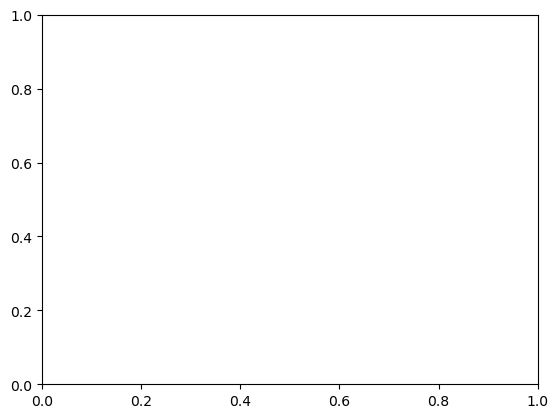

In [628]:
mak = mean_std_ci_queue_lengths["Server_Count"] == 4
mak2 = mean_std_ci_queue_lengths["P_Value"] == 0.99
filtered_dataset = mean_std_ci_queue_lengths[mak]
filtered_dataseto = filtered_dataset[mak2]
filtered_datasetos = filtered_dataseto["Mean_Queue_Length"].rolling(window=1).mean()
x = np.linspace(0, 19999, 20000)
plt.plot(x, filtered_datasetos)

In [637]:
mean_std_ci_queue_lengths

,Server_Count,P_Value,Time_Second,Mean_Queue_Length,Std_Dev_Queue_Length,CI_Lower_Bound,CI_Upper_Bound
0,1.0,0.85,100.0,1.967448,1.414404,1.090791,2.844105
1,1.0,0.85,200.0,1.955714,0.801523,1.458925,2.452503
2,1.0,0.90,100.0,2.735496,1.010296,2.109308,3.361683
3,1.0,0.90,200.0,2.983408,1.198578,2.240521,3.726294
4,1.0,0.95,100.0,3.297672,1.364073,2.452211,4.143133
5,1.0,0.95,200.0,3.488314,1.500123,2.558528,4.418100
6,1.0,0.99,100.0,2.377948,0.752453,1.911573,2.844324
7,1.0,0.99,200.0,3.423988,1.244219,2.652813,4.195163
8,2.0,0.85,100.0,2.046722,0.548890,1.706516,2.386927
9,2.0,0.85,200.0,2.099605,0.663919,1.688104,2.511107


In [638]:
mean_std_ci_waiting_time

,Server_Count,P_Value,Time_Second,Mean_Waiting_time,Std_Dev_Waiting_time,CI_Lower_Bound,CI_Upper_Bound
0,1.0,0.85,100.0,2.414756,0.914766,1.847778,2.981734
1,1.0,0.85,200.0,3.218511,1.515040,2.279479,4.157542
2,1.0,0.90,100.0,3.195290,0.930219,2.618735,3.771846
3,1.0,0.90,200.0,3.413039,0.959557,2.818299,4.007778
4,1.0,0.95,100.0,3.096127,0.647404,2.694862,3.497393
5,1.0,0.95,200.0,4.099382,1.559411,3.132849,5.065915
6,1.0,0.99,100.0,2.852040,0.847797,2.326570,3.377510
7,1.0,0.99,200.0,3.865302,1.097295,3.185192,4.545412
8,2.0,0.85,100.0,1.843804,0.332631,1.637637,2.049971
9,2.0,0.85,200.0,2.005586,0.404951,1.754595,2.256577


[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800

/var/folders/j1/w77jn90n4xz0jc6gqk110_x00000gn/T/ipykernel_45448/866611507.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_dataseto = filtered_dataset[mak2]
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


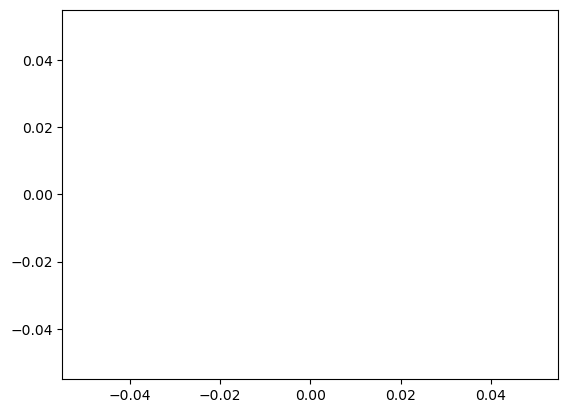

In [629]:
mak = mean_std_ci_waiting_time["Server_Count"] == 1
mak2 = mean_std_ci_waiting_time["P_Value"] == 0.99
filtered_dataset = mean_std_ci_waiting_time[mak]
filtered_dataseto = filtered_dataset[mak2]
filtered_datasetos = filtered_dataseto["Mean_Waiting_time"]
filtered_datasetos = np.array(filtered_datasetos)
ma = []
for x in range(0, 20000, 100):
    ma.append(x)
print(ma)
filtered_datasetoso = [np.mean(filtered_datasetos[n_customers-100:n_customers]) for n_customers in ma]
x = np.linspace(0, 19999, 20000)
plt.plot(ma, filtered_datasetoso)

In [520]:
waiting_time_general_stat

,Server_Count,P_Value,Mean_Waiting_time,Mean_Within_Std_of_Waiting_time,Customers_Served,Mean_queue,Std_within_Waiting_time,Std_Dev_Waiting_time,Std_Dev_Customers_served,Std_Dev_Queue,...,CI_Lower_Bound_Customers_Served,CI_Upper_Bound_Customers_Served,CI_Lower_Bound_Queue,CI_Upper_Bound_Queue,Min_waiting_time,Max_waiting_time,Min_queue,Max_queue,Min_customers_served,Max_customers_served
0,1.0,0.85,3.432077,8.635335,17016.72,2.571134,1.638527,0.190134,144.433935,2.571134,...,16988.410949,17045.029051,2.067192,3.075076,0.000137,838.851129,0.0,23.0,16560.0,17326.0
1,1.0,0.90,4.317495,15.297585,17995.91,3.491707,3.751692,0.326025,130.040001,3.491707,...,17970.422160,18021.397840,2.807333,4.176082,0.000104,1760.873373,0.0,25.0,17719.0,18293.0
2,1.0,0.95,6.655866,41.933825,19006.08,5.912704,18.901148,1.192020,141.913331,5.912704,...,18978.264987,19033.895013,4.753814,7.071594,0.000341,8253.399486,0.0,39.0,18642.0,19295.0
3,1.0,0.99,13.506591,145.444953,19776.11,15.688858,72.497711,4.219513,135.594387,15.688858,...,19749.533500,19802.686500,12.613841,18.763874,0.000856,18444.994728,0.0,113.0,19451.0,20197.0
4,2.0,0.85,2.200391,4.417867,34006.03,2.540656,0.507862,0.066191,182.921319,2.540656,...,33970.177421,34041.882579,2.042688,3.038625,0.000046,381.890191,0.0,25.0,33609.0,34432.0
5,2.0,0.90,2.664304,7.560324,35981.87,3.497904,1.320858,0.121640,190.642789,3.497904,...,35944.504013,36019.235987,2.812315,4.183493,0.000176,819.646296,0.0,30.0,35560.0,36539.0
6,2.0,0.95,3.946641,20.744169,37999.67,6.119342,7.085568,0.457210,193.311048,6.119342,...,37961.781035,38037.558965,4.919951,7.318733,0.000256,4099.882427,0.0,47.0,37557.0,38454.0
7,2.0,0.99,9.104270,112.891767,39565.90,19.390872,67.374258,3.108391,204.913177,19.390872,...,39525.737017,39606.062983,15.590261,23.191483,0.000106,18525.897595,0.0,110.0,39057.0,40056.0
8,4.0,0.85,1.567655,2.371810,67989.27,2.429514,0.168612,0.027532,249.360256,2.429514,...,67940.395390,68038.144610,1.953329,2.905699,0.000027,209.529488,0.0,29.0,67494.0,68557.0
9,4.0,0.90,1.838999,3.939698,72036.61,3.525113,0.552040,0.051577,241.840315,3.525113,...,71989.209298,72084.010702,2.834191,4.216035,0.000145,462.857230,0.0,35.0,71467.0,72711.0
